# W maze demo

Here we load sorted unit data obtained from MatClust to identify putative place cells. The recording session has two runs on a w-maze, each one followed by a period of rest. Each segment (both run and rest segments) is about 15 minutes in duration. 

Data was recorded by Joshua Chu, with a Spikegadgets wireless headstage, on July 8th, 2017, from the CA! area of a male Long-Evans rat named `install`.

Notebook was created by Etienne Ackermann.

## 2. Obtain example data

We will look for data in the `example-data\w-maze\` directory inside your current working directory. If the data doesn't exist, we will download it from https://github.com/nelpy/example-data, and save it to your local machine. 

If you already have the data, it won't be downloaded again.

In particular, we will download two files, namely
 1. `trajectory.videoPositionTracking` which is a binary file with (x,y) position coordinate pairs and timestamps, and
 2. `spikes.mat` which is a Matlab file containing information about sorted units (cells) obtained by using MatClust (https://bitbucket.org/mkarlsso/matclust).

In [71]:
import os
import requests

# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

datadir = os.path.join(os.getcwd(), 'example-data\w-maze')
os.makedirs(datadir, exist_ok=True)

filenames = []
filenames.append(os.path.join(datadir, 'trajectory.videoPositionTracking'))
filenames.append(os.path.join(datadir, 'spikes.mat'))
urls = []
urls.append('https://github.com/nelpy/example-data/raw/master/w-maze/trajectory.videoPositionTracking')
urls.append('https://github.com/nelpy/example-data/raw/master/w-maze/spikes.mat')

for filename, url in zip(filenames, urls):
    if os.path.exists(filename):
        print('you already have the example data, skipping download...')
    else:
        print('downloading data from {}'.format(url))
        # Streaming, so we can iterate over the response.
        r = requests.get(url, stream=True)

        # Total size in bytes.
        total_size = int(r.headers.get('content-length', 0)); 
        chunk_size = 1024 # number of bytes to process at a time (NOTE: progress bar unit only accurate if this is 1 kB)

        with open(filename, 'wb+') as f:
            for data in tqdm(r.iter_content(chunk_size), total=int(total_size/chunk_size), unit='kB'):
                f.write(data)
            
        print('data saved to local directory {}'.format(filename))

filename_pos = filenames[0]
filename_spikes = filenames[1]

you already have the example data, skipping download...
you already have the example data, skipping download...


In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import struct

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

# assume default aesthetics
npl.setup()

%matplotlib inline

In [10]:
def print_header(filename, timeout=50):
    """Reads header lines from a SpikeGadgets .rec file, and prints it to screen."""
    linecount = 0
    with open(filename, 'rb') as fileobj:
        instr = fileobj.readline()
        linecount += 1
        while (instr != b'<End settings>\n') :
            print(instr)
            instr = fileobj.readline()
            if linecount > timeout:
                break
    print(instr)

In [11]:
print_header(filename_pos)

b'<Start settings>\n'
b'threshold: 199\n'
b'dark: 0\n'
b'clockrate: 30000\n'
b'camera resolution: 640x480\n'
b'pixel scale: 0 pix/cm\n'
b'Fields: <time uint32><xloc uint16><yloc uint16><xloc2 uint16><yloc2 uint16>\n'
b'<End settings>\n'


In [12]:
n_packets = 500000
timestamps = []
x1 = []
y1 = []
x2 = []
y2 = []
ii = 0
with open(filename_pos, 'rb') as fileobj:
    instr = fileobj.readline()
    while (instr != b'<End settings>\n') :
        print(instr)
        instr = fileobj.readline()
    for packet in iter(lambda: fileobj.read(12), ''):
        if packet:
            ts_ = struct.unpack('<L', packet[0:4])[0]
            x1_ = struct.unpack('<H', packet[4:6])[0]
            y1_ = struct.unpack('<H', packet[6:8])[0]
            x2_ = struct.unpack('<H', packet[8:10])[0]
            y2_ = struct.unpack('<H', packet[10:12])[0]
            timestamps.append(ts_)
            x1.append(x1_)
            y1.append(y1_)
            x2.append(x2_)
            y2.append(y2_)
        else:
            break
        if ii >= n_packets:
            print('Stopped before reaching end of file')
            break

b'<Start settings>\n'
b'threshold: 199\n'
b'dark: 0\n'
b'clockrate: 30000\n'
b'camera resolution: 640x480\n'
b'pixel scale: 0 pix/cm\n'
b'Fields: <time uint32><xloc uint16><yloc uint16><xloc2 uint16><yloc2 uint16>\n'


# Get session boundaries and trajectory objects

In [13]:
# we estimate large periods of inactivity as periods where the animal's estimated position did not move for at least 10 seconds
minLength = 1800 # 30 seconds @ 60 fps
bounds, _, _ = nel.utils.get_events_boundaries(np.gradient(x1), PrimaryThreshold=0, SecondaryThreshold=0, mode='below', minLength=minLength, ds=1)

FS = 30000
bounds_ts = np.zeros(bounds.shape)
for row in range(len(bounds)):
    for col in range(2):
        bounds_ts[row,col] = timestamps[bounds[row,col]]
        
rest = nel.EpochArray(bounds_ts/FS, domain=nel.EpochArray((timestamps[0]/FS, timestamps[-1]/FS)))
session_epochs = (rest+~rest)
session_epochs._sort()

In [14]:
for ep in session_epochs:
    print(ep.duration)

1:32:265 minutes
18:10:642 minutes
17:06:481 minutes
20:08:130 minutes
15:48:443 minutes


In [15]:
rest

<EpochArray at 0x17b899b60f0: 3 epochs> of duration 34:27:189 minutes

In [16]:
~rest

<EpochArray at 0x17b899aa5f8: 2 epochs> of duration 38:18:772 minutes

In [17]:
pos = nel.AnalogSignalArray(np.vstack((x1, y1)), timestamps=np.array(timestamps)/FS, support=(~rest).shrink(20), fs=60)

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


(190, 540)

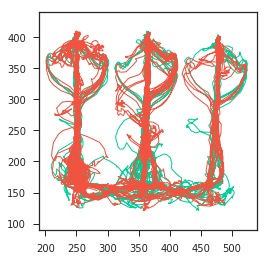

In [18]:
ax = npl.plot2d(pos.simplify(n_points=20000), lw=1)
ax.set_aspect('equal')
ax.set_ylim(90, 440)
ax.set_xlim(190, 540)

In [19]:
# rough pixel-to-cm conversion:
pixels_per_cm = (475-250)/70

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


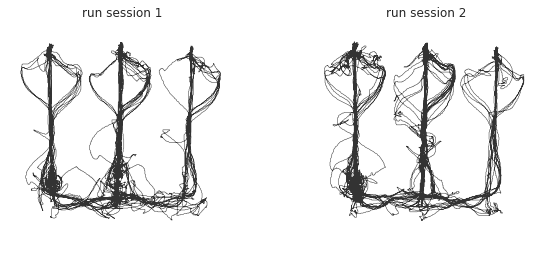

In [20]:
with npl.FigureManager(show=True, figsize=(10,4), nrows=1, ncols=2) as (fig, axes):
    npl.utils.skip_if_no_output(fig)
    ax0, ax1 = axes
    npl.plot2d(pos[0].smooth(sigma=0.1), lw=0.5, color='0.2', ax=ax0)
    npl.plot2d(pos[1].smooth(sigma=0.1), lw=0.5, color='0.2', ax=ax1)
    for ii, ax in enumerate(axes):
        ax.set_aspect('equal')
        ax.set_ylim(90, 440)
        ax.set_xlim(190, 540)
        npl.utils.clear_left_right(ax)
        npl.utils.clear_top_bottom(ax)
        ax.set_title('run session {}'.format(ii+1))


# Load sorted spike data

In [21]:
mat = nel.io.matlab.load(filename_spikes)

In [22]:
# Epoch for which spikes were sorted
session_bounds = nel.EpochArray(mat['spikes'][0][0]['timerange'].ravel()[0])

## Find spike times of sorted cells

In [23]:
spikes = []
ct = 0
num_array = 0
for ii, array in enumerate(mat['spikes']):
    # If empty array, that particular tetrode was not sorted
    if (array.size > 1):
        for jj, subarray in enumerate(array):
            if (subarray.size != 0):
                # Exclude tetrodes with no spikes
                if (len(subarray['time'].ravel()[0]) != 0):
                    spikes.append(subarray['time'].ravel()[0])
                    ct +=1
    elif (array.size == 1):
        if (len(array['time'].ravel()[0]) != 0):
            spikes.append(array['time'].ravel()[0])
            ct +=1
print("Found {} units total".format(ct))

Found 25 units total


In [24]:
st = nel.SpikeTrainArray(timestamps=spikes, support=session_bounds, fs=FS)
st.support

<EpochArray at 0x17b8a22bef0: 1 epoch> of duration 1:11:46:831 hours

In [25]:
rest.domain

<EpochArray at 0x17b8a35c978: 1 epoch> of duration 1:12:45:962 hours

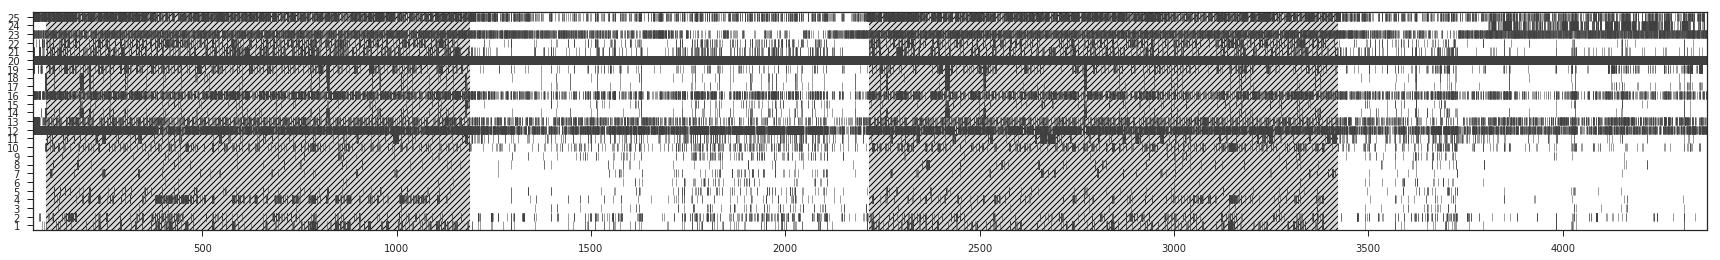

In [26]:
with npl.FigureManager(show=True, figsize=(30,4)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.rasterplot(st, lw=0.5, ax=ax)
    npl.epochplot(~rest, alpha=0.3)
    ax.set_xlim(*session_bounds.time)

In [29]:
sigma_100ms = 0.1
speed2d = nel.utils.dxdt_AnalogSignalArray(pos, smooth=True, sigma=sigma_100ms) / pixels_per_cm

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


In [30]:
run_epochs = nel.utils.get_run_epochs(speed2d.smooth(sigma=0.5), v1=2,v2=1) # original choice

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support
c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


In [31]:
run_epochs

<EpochArray at 0x17b89d6c470: 180 epochs> of duration 15:20:877 minutes

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


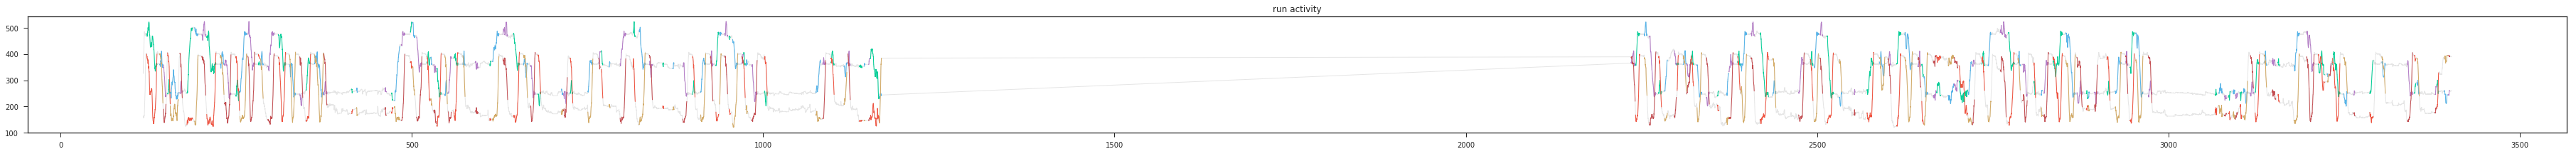

In [32]:
with npl.FigureManager(show=True, figsize=(64,3)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    plt.plot(pos.time, pos.asarray().yvals[0,:], lw=1, alpha=0.2, color='gray')
    plt.plot(pos.time, pos.asarray().yvals[1,:], lw=1, alpha=0.2, color='gray')
    npl.plot(pos[run_epochs], ax=ax, lw=1, label='run')
    
    plt.title('run activity')

In [33]:
st_run = st[run_epochs]

c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified


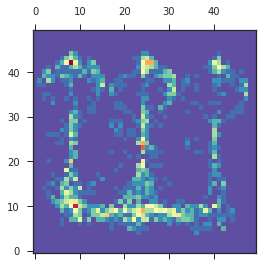

In [34]:
ds_run = 0.5 # 100 ms
ds_50ms = 0.05

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

sigma = 0.2 # smoothing std dev in cm
tc2d = nel.TuningCurve2D(bst=bst_run,
                         extern=pos, 
                         ext_nx=50, 
                         ext_ny=50, 
                         ext_xmin=190, 
                         ext_xmax=540, 
                         ext_ymin=90, 
                         ext_ymax=440, 
                         sigma=sigma, 
                         min_duration=0)

plt.matshow(tc2d.occupancy.T, cmap=plt.cm.Spectral_r)
plt.gca().invert_yaxis()


(<matplotlib.axes._subplots.AxesSubplot at 0x17b904a4978>,
 <matplotlib.image.AxesImage at 0x17b900a3588>)

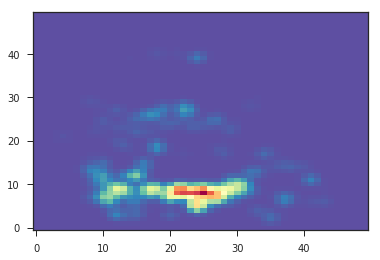

In [35]:
uu=0
uu+=1
npl.imagesc(tc2d.smooth(sigma=6.2).ratemap[uu,:,:], cmap=plt.cm.Spectral_r)

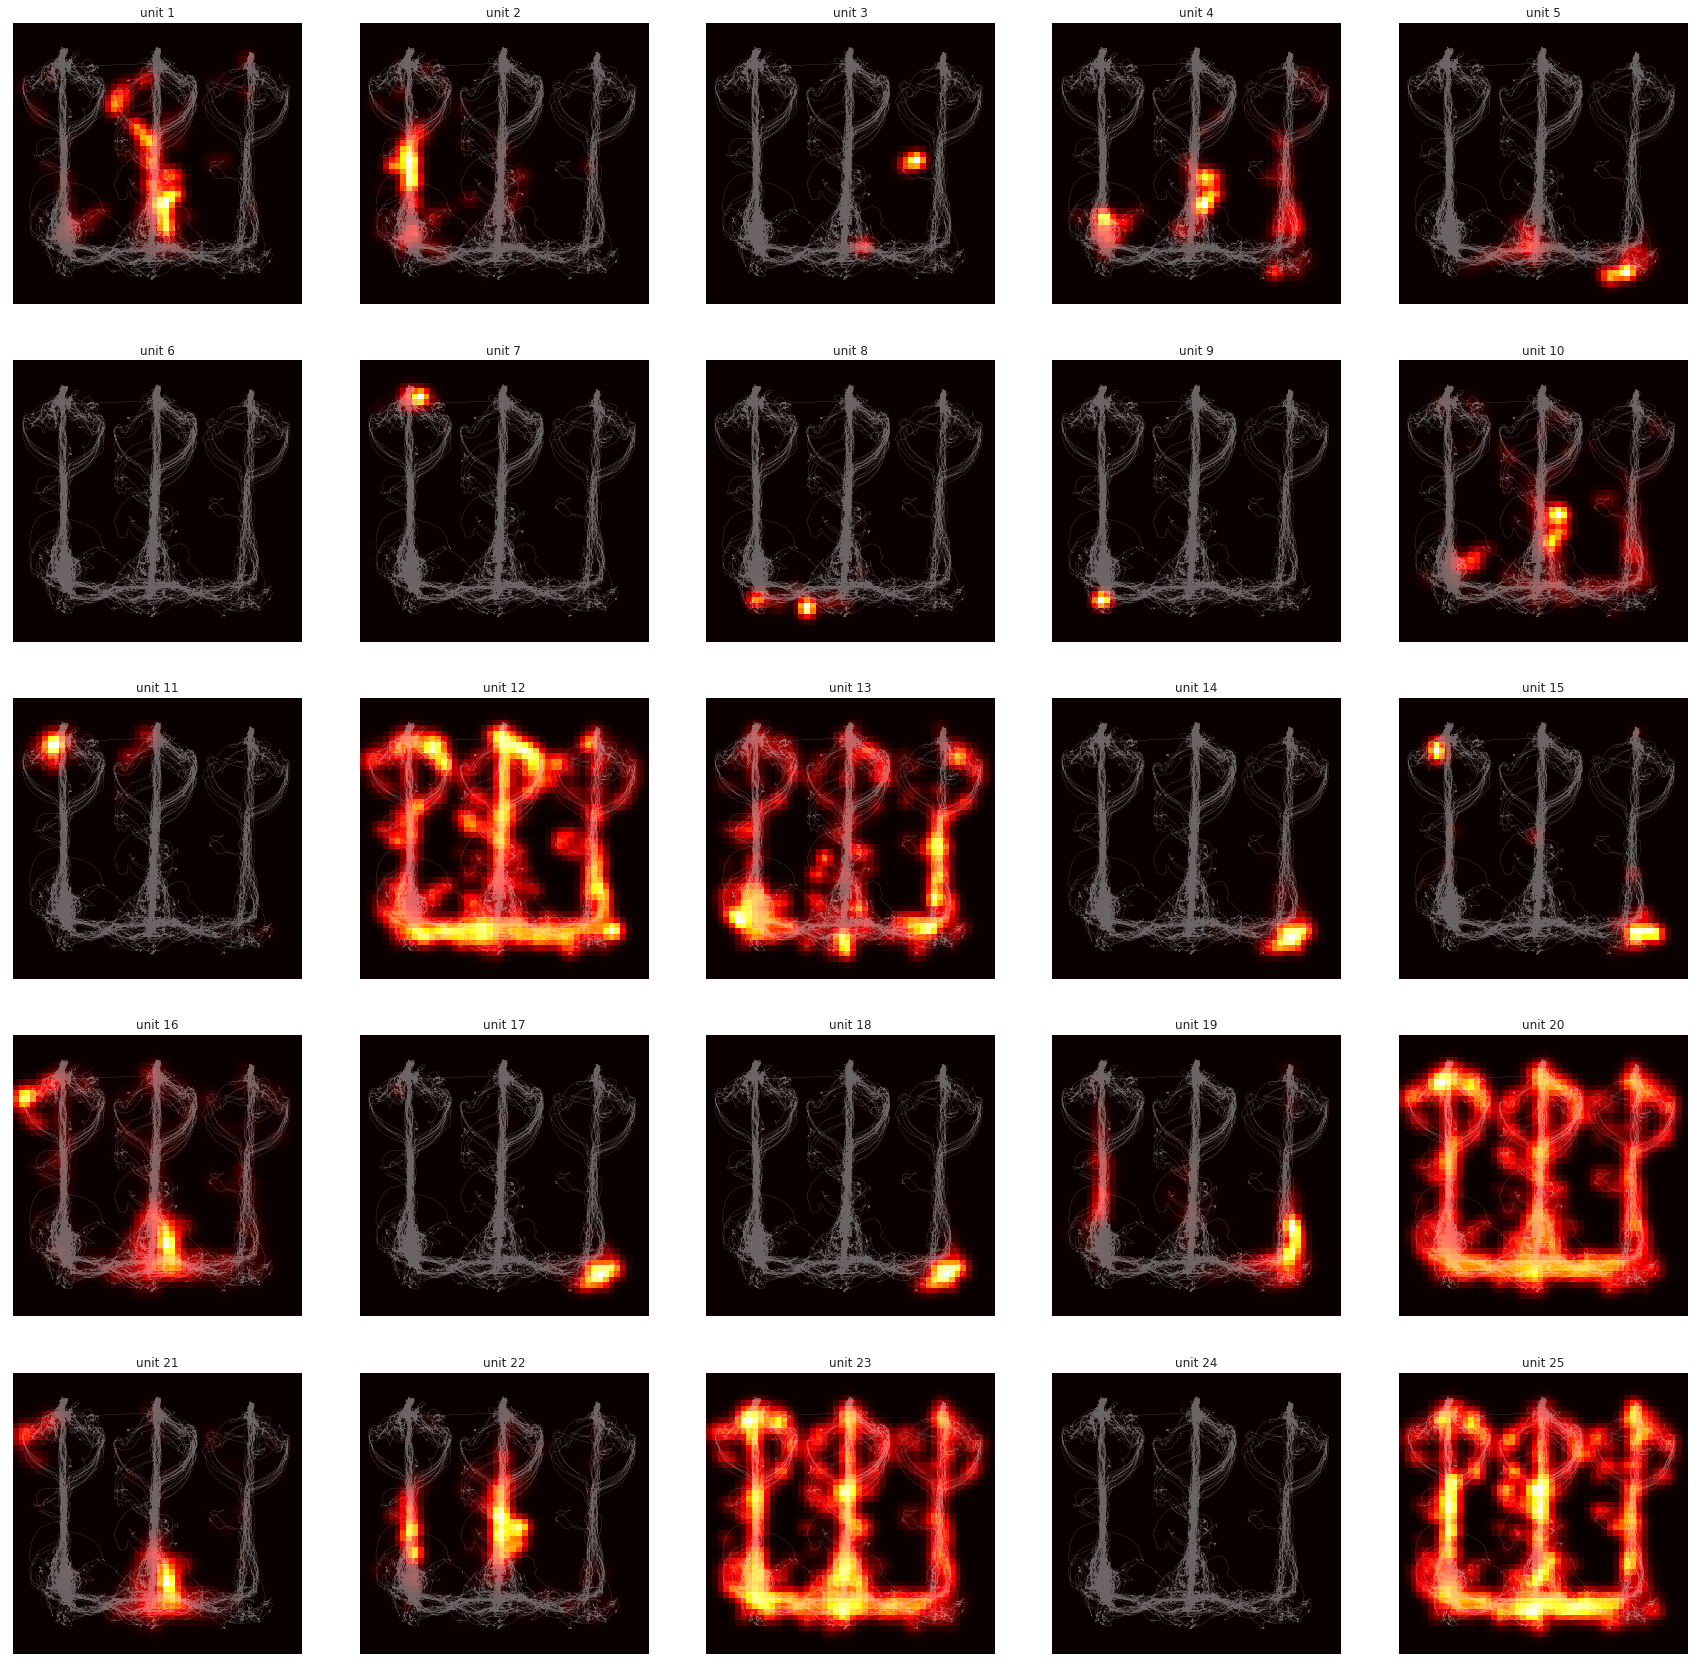

In [36]:
ext_nx=50
ext_ny=50
x0=190; xl=540;
y0=90; yl=440;

xx_left = np.linspace(x0,xl,ext_nx+1)
xx_mid = np.linspace(x0,xl,ext_nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2
yy_left = np.linspace(y0,yl,ext_ny+1)
yy_mid = np.linspace(y0,yl,ext_ny+1)[:-1]; yy_mid += (yy_mid[1]-yy_mid[0])/2

tvals, vals = pos.asarray()
xvals, yvals = vals

sigma_tc = 7
ratemap = tc2d.smooth(sigma=sigma_tc).ratemap

with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, figsize=(30, 30), nrows=5, ncols=5) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        for ii, ax in enumerate(axes.ravel()):
            placefield = ratemap[ii]
            npl.imagesc(x=xx_mid, y=yy_mid, data=placefield.T, cmap=plt.cm.hot, ax=ax)
            ax.plot(xvals, yvals, lw=0.25, color='w', alpha=0.4)
            ax.set_title('unit {}'.format(tc2d.unit_ids[ii]))
            npl.utils.clear_left_right(ax)
            npl.utils.clear_top_bottom(ax)

(190, 540)

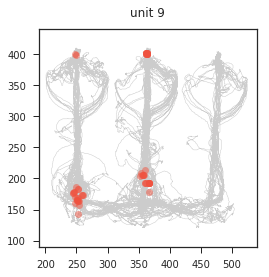

In [37]:
unit_id = 9

ax = npl.plot2d(pos, lw=0.5, c='0.8')
at = st.loc[:,unit_id][pos.support].time[0]
_, pos_at_spikes = pos.asarray(at=at)
ax.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], 'o', alpha=0.5, color=npl.colors.sweet.red)
ax.set_aspect('equal')
ax.set_title('unit {}'.format(unit_id), y=1.03)
ax.set_ylim(90, 440)
ax.set_xlim(190, 540)

(190, 540)

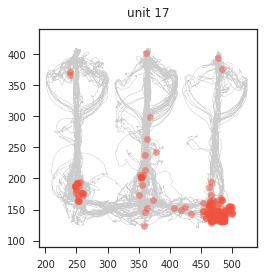

In [70]:
unit_id = 17

ax = npl.plot2d(pos, lw=0.5, c='0.8')
at = st.loc[:,unit_id][pos.support].time[0]
_, pos_at_spikes = pos.asarray(at=at)
ax.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], 'o', alpha=0.5, color=npl.colors.sweet.red)
ax.set_aspect('equal')
ax.set_title('unit {}'.format(unit_id), y=1.03)
ax.set_ylim(90, 440)
ax.set_xlim(190, 540)